# **Traffic Lane Detection** 

In [0]:
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import cv2

This image is: <class 'numpy.ndarray'> with dimesions: (486, 758, 3)


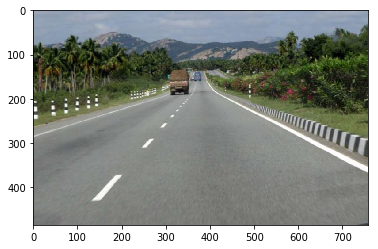

In [0]:
#reading in an image
image = mpimg.imread('solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [0]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines):

    # Calculate slopes and sizes of lanes
    lines = np.squeeze(lines)
    slopes = (lines[:,3]-lines[:,1]) / (lines[:,2] - lines[:,0])
    line_size = np.sqrt((lines[:,2] - lines[:,0])**2 + (lines[:,3]-lines[:,1])**2)

    # Get rid of outlier lines
    slope_threshold = 0.5
    lines = lines[np.abs(slopes)> slope_threshold]
    line_size = line_size[np.abs(slopes)> slope_threshold]
    slopes = slopes[np.abs(slopes)> slope_threshold]

    # Seperate positive and negative slopes, lines, and sizes
    left_slopes, right_slopes = slopes[slopes>0], slopes[slopes<0]
    left_lines, right_lines = lines[slopes>0,:], lines[slopes<0,:]
    left_lane_sizes, right_lane_sizes = line_size[slopes>0], line_size[slopes<0]

    # lanes sorted by size
    left_lane_sizes_sorted = np.argsort(left_lane_sizes)
    right_lane_sizes_sorted = np.argsort(right_lane_sizes)

    # Calculate average slope on the biggest 6 lines.
    left_slope_avg  = left_slopes[left_lane_sizes_sorted][-6::].mean()
    right_slope_avg = right_slopes[right_lane_sizes_sorted][-6::].mean()

    # find y intercept
    # b = y - m * x
    left_x_values, left_y_values = np.concatenate([left_lines[:,0], left_lines[:,2]]), np.concatenate([left_lines[:,1], left_lines[:,3]])
    right_x_values, right_y_values = np.concatenate([right_lines[:,0],right_lines[:,2]]), np.concatenate([right_lines[:,1], right_lines[:,3]])

    left_y_intercept = left_y_values - (left_slope_avg * left_x_values)
    right_y_intercept = right_y_values - (right_slope_avg * right_x_values)

    # find mean y-intercept based on n biggest lines
    left_y_intercept = left_y_intercept[left_lane_sizes_sorted][-6::]
    right_y_intercept = right_y_intercept[right_lane_sizes_sorted][-6::]
    left_y_intercept_avg, right_y_intercept_avg = np.mean(left_y_intercept), np.mean(right_y_intercept)

    imshape = img.shape
    img_floor = imshape[0]
    horizon_line = imshape[0]/1.5

    # calculate new points x = (y - b) / m

    # Right lane points
    max_right_x = (img_floor - right_y_intercept_avg) / right_slope_avg
    min_right_x = (horizon_line - right_y_intercept_avg) / right_slope_avg


    # Left lane points
    min_left_x = (img_floor - left_y_intercept_avg) / left_slope_avg
    max_left_x = (horizon_line - left_y_intercept_avg) / left_slope_avg


    l1 = (int(min_left_x), int(img_floor))
    l2 = (int(max_left_x), int(horizon_line))
    # print('Right points l1 and l2,', l1, l2)
    cv2.line(img, l1, l2, [0, 255, 0], 8)

    r1 = (int(max_right_x), int(img_floor))
    r2 = (int(min_right_x), int(horizon_line))
    # print('Left points l1 and l2,', l1, l2)
    cv2.line(img, r1, r2, [255, 0, 0], 8)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)


In [0]:
def mark_lanes(image):
    if image is None: raise ValueError("no image given to mark_lanes")
    # grayscale the image to make finding gradients clearer
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges_img = cv2.Canny(np.uint8(blur_gray), low_threshold, high_threshold)


    imshape = image.shape
    vertices = np.array([[(0, imshape[0]),
                          (450, 320),
                          (490, 320),
                          (imshape[1], imshape[0]) ]],
                          dtype=np.int32)

    masked_edges = region_of_interest(edges_img, vertices )


    # Define the Hough transform parameters
    rho             = 2           # distance resolution in pixels of the Hough grid
    theta           = np.pi/180   # angular resolution in radians of the Hough grid
    threshold       = 5        # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10       # minimum number of pixels making up a line
    max_line_gap    = 20       # maximum gap in pixels between connectable line segments

    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw the lines on the image
    # initial_img * α + img * β + λ
    marked_lanes = cv2.addWeighted(image, 0.8, line_image, 1, 0)
    return marked_lanes

## Test on Images

In [0]:
#paths = glob.glob('solidWhiteRight.jpg')

#for i,image_path in enumerate(paths):
image_path = "solidWhiteRight.jpg"
image = mpimg.imread(image_path) 
result = mark_lanes(image)
#plt.subplot(2,3,i+1)
plt.imshow(result)
mpimg.imsave('detected.jpg', result)

IndexError: ignored

## Test on Videos


White Lane

In [0]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(mark_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4







  0%|          | 0/222 [00:00<?, ?it/s]




  2%|▏         | 5/222 [00:00<00:05, 42.69it/s]




  5%|▍         | 10/222 [00:00<00:04, 44.37it/s]




  7%|▋         | 16/222 [00:00<00:04, 46.21it/s]




  9%|▉         | 21/222 [00:00<00:04, 46.34it/s]




 12%|█▏        | 26/222 [00:00<00:04, 46.34it/s]




 14%|█▍        | 31/222 [00:00<00:04, 46.35it/s]




 16%|█▌        | 36/222 [00:00<00:04, 46.33it/s]




 18%|█▊        | 41/222 [00:00<00:03, 46.39it/s]




 21%|██        | 46/222 [00:01<00:04, 40.12it/s]




 23%|██▎       | 50/222 [00:01<00:05, 28.81it/s]




 24%|██▍       | 54/222 [00:01<00:07, 23.93it/s]




 26%|██▌       | 57/222 [00:01<00:07, 20.97it/s]




 27%|██▋       | 60/222 [00:01<00:07, 20.52it/s]




 28%|██▊       | 63/222 [00:02<00:08, 18.06it/s]




 30%|██▉       | 66/222 [00:02<00:08, 17.63it/s]




 31%|███       | 68/222 [00:02<00:08, 17.87it/s]




 32%|███▏      | 70/222 [00:02<00:08, 17.32it/s]




 33%|███▎      | 73/222 [00:02<00:08, 17.41it/s]




[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.45 s, sys: 663 ms, total: 5.11 s
Wall time: 13.1 s


In [0]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(mark_lanes)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



100%|█████████▉| 681/682 [00:38<00:00, 17.61it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 24 s, sys: 2.85 s, total: 26.9 s
Wall time: 40.2 s
